# Final exam 2016

Source of the data: https://www.prontocycleshare.com/data

Data file link: https://s3.amazonaws.com/pronto-data/open_data_year_two.zip

Example of analyzing this dataset: https://jakevdp.github.io/blog/2015/10/17/analyzing-pronto-cycleshare-data-with-python-and-pandas/

### Setup the environment.

In [1]:
import re
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

sns.set_context('notebook')
pd.set_option('float_format', '{:6.2f}'.format)

data_file = 'https://s3.amazonaws.com/pronto-data/open_data_year_two.zip'
data_path = 'cycle_share.zip'

import os.path

if not os.path.isfile(data_path):
    import requests

    response = requests.get(data_file)
    with open(data_path, "wb") as file:
        file.write(response.content)

## Q1 (5 points)

- Show contents of the zipfile `cycle_share.zip`.

In [2]:
zf = zipfile.ZipFile(data_path)
files = zf.namelist()

print(files)

['2016_trip_data.csv', '2016_station_data.csv', 'README.txt', '2016_weather_data.csv']


## Q2 (20 points)

- Import `2016_trip_data.csv` directly from the zipfile into Pandas DataFrame.
- Make sure that `starttime` and  `stoptime` are of `datetime64[ns]` type, while `usertype` and `gender` are categorical.
- Print variable types.
- Print first five rows of the following columns: `trip_id`, `Date`, `starttime`, `tripduration`, `gender`.
- Print value counts for the two categorical variables in the dataset.

The data is saved in 'exam_data.hdf', table 'trips'.

In [3]:
trips = pd.read_csv(zf.open(files[0]), parse_dates=['starttime', 'stoptime'],
                    infer_datetime_format=True,
                    dtype={'usertype': 'category', 'gender': 'category'})
trips['Date'] = pd.DatetimeIndex(trips['starttime']).date.astype('datetime64')

trips.to_hdf('exam_data.hdf', 'trips', format='table')

print(trips.dtypes)
print(trips[['trip_id', 'Date', 'starttime', 'tripduration', 'gender']].head())
for col in ['usertype', 'gender']:
    print(trips[col].value_counts())

trip_id                       int64
starttime            datetime64[ns]
stoptime             datetime64[ns]
bikeid                       object
tripduration                float64
from_station_name            object
to_station_name              object
from_station_id              object
to_station_id                object
usertype                   category
gender                     category
birthyear                   float64
Date                 datetime64[ns]
dtype: object
   trip_id       Date           starttime  tripduration  gender
0      431 2014-10-13 2014-10-13 10:31:00        985.93    Male
1      432 2014-10-13 2014-10-13 10:32:00        926.38    Male
2      433 2014-10-13 2014-10-13 10:33:00        883.83  Female
3      434 2014-10-13 2014-10-13 10:34:00        865.94  Female
4      435 2014-10-13 2014-10-13 10:34:00        923.92    Male
Member                    146171
Short-Term Pass Holder     89894
Name: usertype, dtype: int64
Male      112940
Female     30330
Other

## Q3 (20 points)

- Import `2016_weather_data.csv` directly from the zipfile into Pandas DataFrame.
- Make sure that `Date` is of `datetime64[ns]` type, while `Events` is categorical.
- Print variable types.
- Print first five rows of the following columns: `trip_id`, `Date`, `starttime`, `tripduration`, `gender`.
- Note that the values of `Events` column can be, for example, 'Fog-Rain' and 'Fog , Rain'. Rename the latter to the former.
- Print value counts for the `Events` column.

In [4]:
weather = pd.read_csv(zf.open(files[3]), na_values=['-'],
                      parse_dates=['Date'], infer_datetime_format=True)
weather.columns = weather.columns.str.strip()
weather['Events'] = weather['Events'].str.replace('\ ,\ ', '-').astype('category')

weather.to_hdf('exam_data.hdf', 'weather', format='table')

print(weather.dtypes)
print(weather[['Date', 'Mean_Temperature_F', 'Precipitation_In', 'Events']].head())
print(weather['Events'].value_counts())

Date                          datetime64[ns]
Max_Temperature_F                      int64
Mean_Temperature_F                   float64
Min_TemperatureF                       int64
Max_Dew_Point_F                        int64
MeanDew_Point_F                        int64
Min_Dewpoint_F                         int64
Max_Humidity                           int64
Mean_Humidity                          int64
Min_Humidity                           int64
Max_Sea_Level_Pressure_In            float64
Mean_Sea_Level_Pressure_In           float64
Min_Sea_Level_Pressure_In            float64
Max_Visibility_Miles                   int64
Mean_Visibility_Miles                  int64
Min_Visibility_Miles                   int64
Max_Wind_Speed_MPH                     int64
Mean_Wind_Speed_MPH                    int64
Max_Gust_Speed_MPH                   float64
Precipitation_In                     float64
Events                              category
dtype: object
        Date  Mean_Temperature_F  Precipi

## Q4 (20 points)

- Find the most popular station pairs. Note that a trip from A to B is counted the same as from B to A. Also exclude trips that start and finish on the same station.
- Save the reuslt to the Excel file.
- Print the names of the two most popular destinations from the list.

In [5]:
trips = pd.read_hdf('exam_data.hdf', 'trips')

def station_pair(row):
    return ' and '.join(sorted(row[['from_station_id', 'to_station_id']]))

trips = trips[trips['from_station_id'] != trips['to_station_id']]
trips['station_pair'] = trips.apply(station_pair, axis=1)
df = trips.groupby(['station_pair'])['trip_id'].count()
pd.DataFrame(df).to_excel('popular_stations.xlsx', sheet_name='Popular stations')

print(df.nlargest(10))
print(trips.ix[trips['station_pair'] == df.argmax(), ['from_station_name', 'to_station_name']].iloc[0].values)

station_pair
WF-01 and WF-04      3896
BT-01 and CBD-13     2063
PS-05 and WF-01      1699
CBD-05 and WF-01     1486
SLU-02 and SLU-04    1374
BT-01 and WF-04      1270
CH-02 and CH-08      1270
BT-01 and CBD-06     1252
SLU-02 and SLU-15    1251
EL-03 and SLU-17     1246
Name: trip_id, dtype: int64
['Seattle Aquarium / Alaskan Way S & Elliott Bay Trail'
 'Pier 69 / Alaskan Way & Clay St']


## Q5 (5 points)

Draw density of log trip duration.

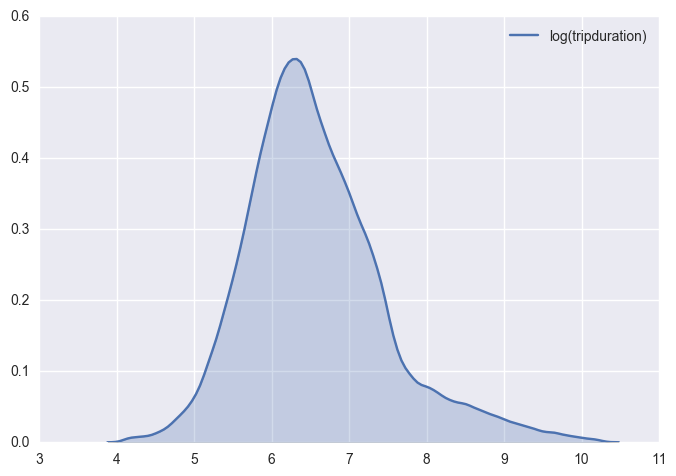

In [6]:
trips = pd.read_hdf('exam_data.hdf', 'trips')

trips['log(tripduration)'] = trips['tripduration'].apply(np.log)
sns.kdeplot(trips['log(tripduration)'], shade=True)
plt.show()

## Q6 (10 points)

Draw density of log trip duration for men and women separately. Exclude value 'Other' from the column `gender`.

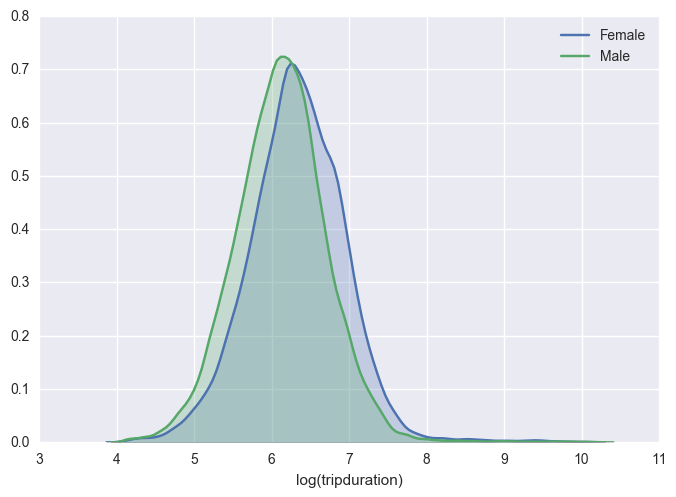

In [7]:
trips = pd.read_hdf('exam_data.hdf', 'trips')

trips['log(tripduration)'] = trips['tripduration'].apply(np.log)
grouped = trips.groupby('gender')
for label, group in grouped:
    if label != 'Other':
        sns.kdeplot(group['log(tripduration)'], shade=True, label=label)
plt.xlabel('log(tripduration)')
plt.show()

## Q7 (15 points)

Count the number of trips for each date and for each usertype. Draw two time series (for each usertype) on the same  plot. Since both are highly seasonal, resample them to weekly frequency.

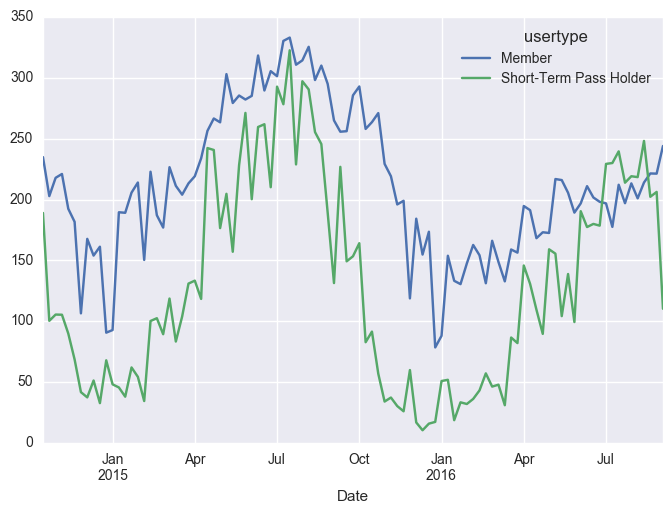

In [8]:
trips = pd.read_hdf('exam_data.hdf', 'trips')

df = trips.groupby(['Date', 'usertype'])['trip_id'].count()
df = df.unstack('usertype').resample('W', how='mean')
df.plot()
plt.show()

## Q8 (15 points)

Compute the average trip duration for each precipitation type (`Events` column in the weather dataset).

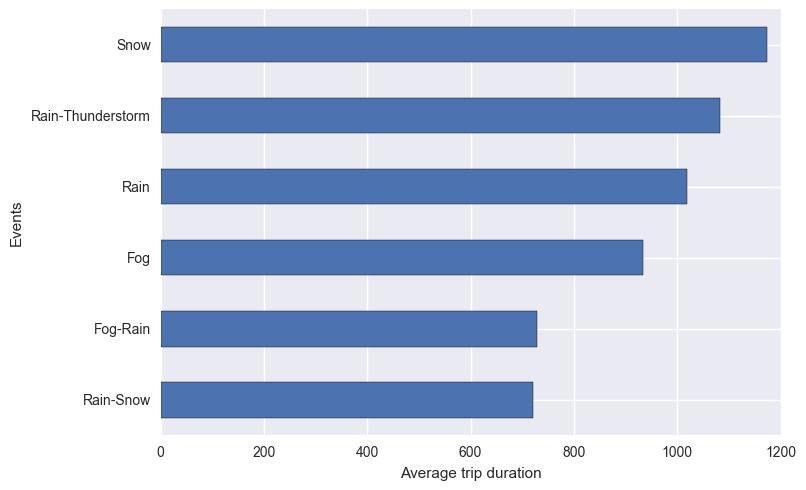

In [9]:
trips = pd.read_hdf('exam_data.hdf', 'trips')
weather = pd.read_hdf('exam_data.hdf', 'weather')

df = pd.merge(trips[['tripduration', 'Date']], weather[['Precipitation_In', 'Events', 'Date']])
df = df.groupby('Events')['tripduration'].mean().sort_values()

df.plot(kind='barh')
plt.xlabel('Average trip duration')
plt.show()

## Q8 (20 points)

Is there any dependence, separated by gender, between log trip duration and two weather variables: average temperature in Celcius and log precipitation? Draw two scatter plots and corresponding regression lines for each explanatory variable and separated by gender. Exclude value 'Other' from the column `gender`.

Note: C = 1.8 x F + 32

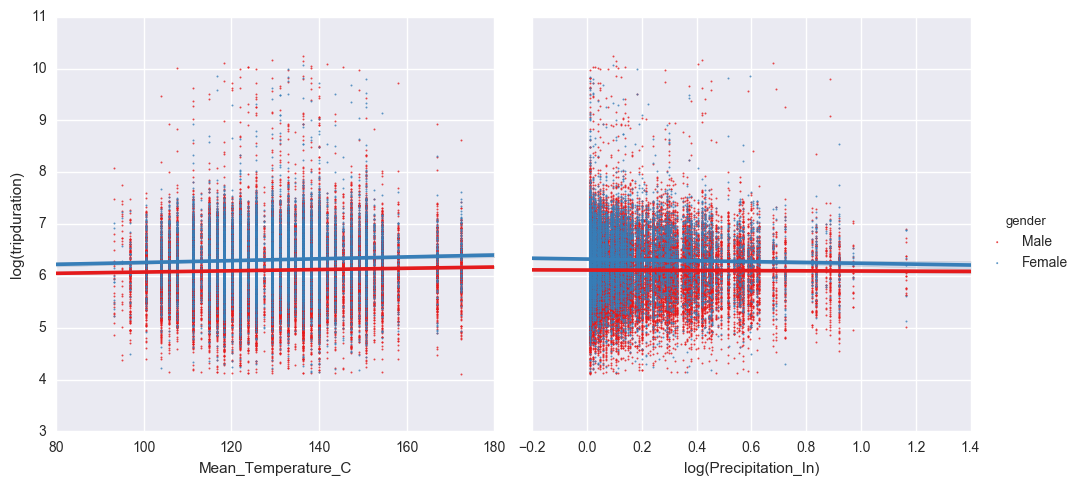

In [10]:
trips = pd.read_hdf('exam_data.hdf', 'trips')
weather = pd.read_hdf('exam_data.hdf', 'weather')

df = pd.merge(trips[['tripduration', 'gender', 'Date']],
              weather[['Mean_Temperature_F', 'Precipitation_In', 'Events', 'Date']])
df = df[(df['Precipitation_In'] > 0) & (df['gender'] != 'Other')]
df['Mean_Temperature_C'] = 1.8 * df['Mean_Temperature_F'] + 32
cols = ['Precipitation_In', 'tripduration']
new_cols = ['log(Precipitation_In)', 'log(tripduration)']
df[new_cols] = df[cols].apply(lambda x: np.log(1 + x))

sns.pairplot(x_vars=['Mean_Temperature_C', 'log(Precipitation_In)'],
             y_vars=['log(tripduration)'], data=df,
             hue='gender', palette="Set1", kind="reg",
             size=5, plot_kws={'scatter_kws': {'s': 2}})
plt.show()